In [125]:
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

The last time we have done logistic regression with softmax so we have a single softmax layer connecting to the mnist inputs. Now, we will do an multilayer perceptron (MLP) and do backpropagation through the network manually. The network architecture is already decided upon and I will show it later on. 

In [126]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_y)

[5 0 4 ... 5 6 8]


In [127]:
print("Training Set Details")
print("Target Categories:", np.unique(train_y))
print("Features: ", train_X.shape, train_X.dtype)
print("Classes:", train_y.shape, train_y.dtype)

print("Classes:", train_y)
print("Feature range:", np.min(train_X).astype(np.int32), np.max(train_X).astype(np.int32))
print("Feature type:",train_X.dtype)
print("Target type:",train_y.dtype)

Training Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (60000, 28, 28) uint8
Classes: (60000,) uint8
Classes: [5 0 4 ... 5 6 8]
Feature range: 0 255
Feature type: uint8
Target type: uint8


In [128]:
print("Test Set Details")
print("Target Categories:", np.unique(test_y))
print("Features: ", test_X.shape, test_X.dtype)
print("Classes:", test_y.shape, test_y.dtype)

print("Classes:", test_y)
print("Feature range:", np.min(test_X).astype(np.int32), np.max(test_X).astype(np.int32))
print("Feature type:",test_X.dtype)
print("Target type:",test_y.dtype)

Test Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (10000, 28, 28) uint8
Classes: (10000,) uint8
Classes: [7 2 1 ... 4 5 6]
Feature range: 0 255
Feature type: uint8
Target type: uint8


The mnist data is already split for us in two different sets. The training set and the test set are big. 70K values once combined. Also pixel data is ranged from 0-255 so we need to rescale it. Firstly, let's visualize some of the training set and see what we can discover.

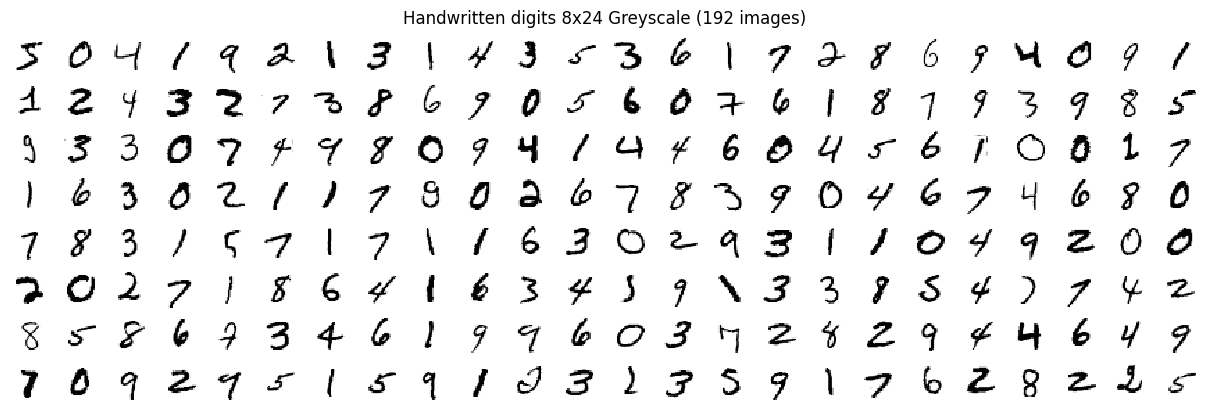

In [129]:
wsize = 24
hsize = 8
fig, axes = plt.subplots(hsize,wsize,figsize=(wsize/2,hsize/2),layout="constrained")

c = 0
for i in range(hsize):
    for j in range(wsize):
        axes[i][j].imshow(train_X[c].reshape((28,28)), interpolation='none', cmap=cm.Greys)
        axes[i][j].axis('off')
        c += 1
plt.suptitle(f"Handwritten digits {hsize}x{wsize} Greyscale ({wsize*hsize} images)")
plt.show()

In [130]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

train_X = feature_scale(train_X, scaled=True) # feature scale the training set
test_X = feature_scale(test_X, scaled=True) # feature scale the test set

We don't forget to feature scale the inputs. Here, we just scale both the training set and the test set just like last time. Since they are images, it's better to normalize them between 0 and 1. We also need to reshape the features to match what we expect.

In [131]:
train_size = train_X.shape[0]
test_size = test_X.shape[0]
train_X = train_X.reshape((train_size,-1)) # reshape the training set
test_X = test_X.reshape((test_size,-1)) # reshape the test set
print("TrainX:",train_X.shape)
print("TestX:",test_X.shape)

TrainX: (60000, 784)
TestX: (10000, 784)


Here we also add a fake bias weight of exactly 1 to every example as a standalone feature.

In [132]:
def add_bias_weight(data):
    m = data.shape[0]
    ones_feature = np.ones(m).reshape((-1,1)) # create a single feature of ones
    data_bias = np.hstack([data, ones_feature])
    return data_bias

train_X_bias = add_bias_weight(train_X)
test_X_bias = add_bias_weight(test_X)
print("TrainX+Bias:",train_X_bias.shape)
print("TestX+Bias:",test_X_bias.shape)

TrainX+Bias: (60000, 785)
TestX+Bias: (10000, 785)


The very first thing to do is to define the prediction function. We will also define the neural network architecture.

![FeedForward Network](images/feedforward_net.png)

The input size is undefined here as we will use different sizes to train the network. The key thing is which activation function we are using which is sigmoid for the hidden layers. Then the specific architecture goes 256 neurons which connect to the inputs, then 128 neurons which connect to the 256 neurons, then the 10 neurons which connect to the 128 layer, and then finally the softmax layer applied on the 10 neurons. The diagram above is easier to interpret and visualize. In total, we have 3 layers that are to be learned by the neural net. A sample feedforward predictor can easily be computed as a series of matrix multiplications and activation non-linearities. Here we can define this custom specific network as 
$ softmax(\sigma(\sigma (xW_1)W_2)W_3) $ where the $\sigma$ is the sigmoid activation function and the $W_i$ is the weight matrix for the $i$-th layer. Of course, this is a vector valued function which returns us the 10 class labels of probabilities. So, let's implement this prediction function first. 

In [189]:
def initialize_mlp_weight_matrices(feature_size, layer_sizes): # TODO - Fix the bias term
    weight_matrices = []
    previous_layer_size = feature_size
    for layer_size in layer_sizes:
        weight_matrix = np.random.random((previous_layer_size, layer_size)) * 0.01 # make sure to use smarter initialization strategies
        weight_matrices.append(weight_matrix)
        previous_layer_size = layer_size
    return weight_matrices

We first need weight matrices first. I've made a general function for creating weight matrices for an mlp using only the layer sizes. For the mnist dataset, I initially tried uniform random distribution between 0.0 and 1.0 but it didn't work so the weight initialization turned out to be poor. Then I shifted it to be between -0.01 and 0.01 which worked much better in practice. Eventually, I will use xavier-glorot initialization which is even better than this. 

In [134]:
def create_mini_batches(x, y, batch_size):
    size = x.shape[0]
    indices = np.arange(size)
    np.random.shuffle(indices)
    shuffled_x = np.take(x, indices, axis=0)
    shuffled_y = np.take(y, indices, axis=0)
    
    batches = size // batch_size
    minibatches_x = np.array_split(shuffled_x, batches)
    minibatches_y = np.array_split(shuffled_y, batches)

    return minibatches_x, minibatches_y

Last time, we performed logistic regression using the full training set and it was really slow. This is because the matrices we're too big to operate on and do matrix multiplication. Instead of using the full training set, we can use mini batches of the training set and gradient descent will still work. We can choose any batch size but it is typically to choose a power of 2. 

In [200]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [183]:
def softmax(x):
    D = -np.max(x, axis=1) # D constant for the log sum exp trick. Useful to deal with limited precision, but the output is the exact same as the original sigmoid

    ez = np.exp((x.T + D).T)
    return ez / np.sum(ez, axis=1).reshape((-1,1))

For the softmax function, I had issues with vanishing gradients. Eventually I noticed the weight matrices were becoming 0. A common solution to this problem is to do the log sum exp trick for the softmax function since the exponents can explode to infinity. Doing this trick is key for numeric stability because otherwise there might be 0's or inf's. Of course, this trick is also nice since it doesn't change the softmax output at all. This softmax is exactly the same as the classical softmax everyone is used to. It was initially surprising since float64 values can represent very high numbers but even with that, the gradients vanished. But this trick actually made learning perform well. We can also apply a similar trick to the sigmoid activation function since it also uses exponentials, however it has diminishing returns and turns out to be fine in practice. 

In [180]:
def predict(weight_matrices, batch_x, epsilon=1e-15):
    prediction = batch_x # m k
    for i in range(len(weight_matrices)):
        prediction = prediction @ weight_matrices[i] # matrix multiply by the previous output
        if i == len(weight_matrices) - 1: # at the very last layer don't apply sigmoid
            break
        prediction = sigmoid(prediction)

    softmax_predict = softmax(prediction) # pass it through a softmax
    prediction = np.clip(softmax_predict, epsilon, 1 - epsilon) # clip to avoid overflow issues
    return prediction

Here the prediction function is very natural. Just using the formula above, we just successively multiply the input matrix and apply the activation_function (sigmoid) on top of it per layer. At the last layer, we shouldn't use the sigmoid as we are going to use softmax anyways. Once we change the prediction function, the loss function stays the same since it depends directly on the prediction. 

In [138]:
def onehot_matrix(a, categories):
    a = a.flatten()
    return np.eye(categories)[a]

In [139]:
def log_loss_cost(weight_matrices, x, y, categories):
    onehot = onehot_matrix(y, categories) # m k
    softmax_prob = predict(weight_matrices, x) # m k
    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    return -np.mean(overm) # 1

In [201]:
def compute_gradients(weight_matrices, batch_x, batch_y, categories, epsilon=1e-15):
    m = batch_x.shape[0] # number of batched examples
    k = categories # number of categories

    gradient_matrices = []
    for weight_matrix in weight_matrices:
        gradient_matrices.append(np.zeros_like(weight_matrix))
    # create the gradient matrices

    onehot = onehot_matrix(batch_y, k) # m k
    # create the onehot labels

    W0 = batch_x @ weight_matrices[0]
    W0_sigmoid = sigmoid(W0) # layer 1 - 256

    W1 = W0_sigmoid @ weight_matrices[1]
    W1_sigmoid = sigmoid(W1) # layer 2 - 128

    prediction = W1_sigmoid @ weight_matrices[2] # layer 3 - 10

    softmax_prob = softmax(prediction) # pass it through a softmax
    softmax_prob = np.clip(softmax_prob, epsilon, 1 - epsilon) # clip to avoid overflow issues
    # compute the softmax probability matrix

    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    loss = -np.mean(overm) # 1
    # compute the loss value

    diff = softmax_prob - onehot # m k
    dw2 = np.matmul(W1_sigmoid.T, diff) # 128 k
    dw1_sigmoid = np.matmul(diff, weight_matrices[2].T) # k 128
    dsigmoid = W1_sigmoid * (1 - W1_sigmoid) * dw1_sigmoid # k 128

    dw1 = np.matmul(W0_sigmoid.T, dsigmoid) # 256 128
    dw0_sigmoid = np.matmul(dsigmoid, weight_matrices[1].T) # k 256
    dsigmoid = W0_sigmoid * (1 - W0_sigmoid) * dw0_sigmoid # k 256

    dw0 = np.matmul(batch_x.T, dsigmoid) # n 256
    # begin the backpropagation

    gradient_matrices[0] = dw0
    gradient_matrices[1] = dw1
    gradient_matrices[2] = dw2
    # assign the gradient matrices to the array of matrices

    gradient_matrices[0] = np.clip(gradient_matrices[0], -1.0, 1.0)
    gradient_matrices[1] = np.clip(gradient_matrices[1], -1.0, 1.0)
    gradient_matrices[2] = np.clip(gradient_matrices[2], -1.0, 1.0)
    # before returning the gradient matrices, let's clip them between -1 and 1 to avoid exploding gradients

    return gradient_matrices

In [271]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    _, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Batch")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

The big difference for this gradient descent function is that now we're using mini batches. Also, the iterations become the epochs which is another term for an iteration but over the full training set. 

In [265]:
def gradient_descent(x, y, gradient_func, cost_func, layer_sizes, learning_rate=0.01, max_epochs=1000, batch_size=64):
    y = y.reshape((-1,1)) # output classes
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    k = np.unique(y).shape[0] # number of categories

    weight_matrices = initialize_mlp_weight_matrices(n, layer_sizes) # initialize weight matrices for each layer

    costs = np.empty(0)

    for epoch in range(max_epochs):
        minibatches_x, minibatches_y = create_mini_batches(x, y, batch_size)
        
        for batch_x, batch_y in zip(minibatches_x, minibatches_y):
            gradient_matrices = gradient_func(weight_matrices, batch_x, batch_y, k)

            for i in range(len(layer_sizes)):
                weight_matrices[i] -= learning_rate * gradient_matrices[i]
            # update the weights per each matrix
            
            current_cost = cost_func(weight_matrices, batch_x, batch_y, k)
            costs = np.append(costs, current_cost)
            # add to array for visualization
    return weight_matrices, costs

layer_sizes = [256,128,10]
weight_matrices, costs = gradient_descent(train_X_bias, train_y, compute_gradients, log_loss_cost, layer_sizes, learning_rate=0.01, max_epochs=40, batch_size=64)

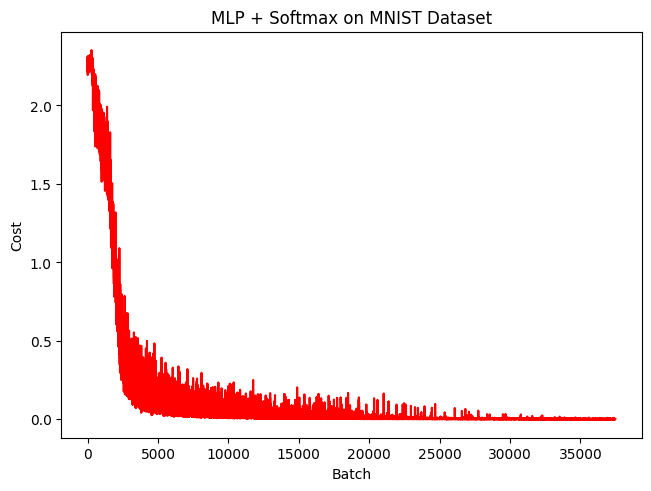

In [272]:
show_cost_graph(costs, "MLP + Softmax on MNIST Dataset", "red")

In [267]:
print("Initial cost",costs[0])
print("Final cost",costs[-1])

Initial cost 2.265436774453948
Final cost 0.0023167887766410685


Wait, look at this. The final cost is not much better than the initial cost. This means that the model really didn't learn properly. Also, when I ran this, it was really slow to execute. This is because the matrices are so big $(60K, 784)$ just for the feature matrix, that it actually takes quite a while to do matrix multiplication on such an enormous matrix. Eventually, I'll have to use mini-batch gradient descent to make the matrices much smaller and execution time much faster.

In [146]:
def get_prediction_categories(probabilities):
    return np.argmax(probabilities,axis=1)

In [268]:
test_samples = test_X_bias.shape[0]
batches_x, batches_y = create_mini_batches(test_X_bias, test_y, 64)

prediction_test_set_categories = np.array([])
observed_test_set_categories = np.array([])

for batch_x, batch_y in zip(batches_x, batches_y):
    batch_prediction_prob = predict(weight_matrices, batch_x)
    batch_categories = get_prediction_categories(batch_prediction_prob)
    prediction_test_set_categories = np.append(prediction_test_set_categories, batch_categories)
    observed_test_set_categories = np.append(observed_test_set_categories, batch_y)

score_percentage = accuracy_score(observed_test_set_categories, prediction_test_set_categories) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(observed_test_set_categories, prediction_test_set_categories, normalize=False))
print("misclassifications:",test_samples - misclassifications)

Accuracy: 97.95 %
misclassifications: 205


So I computed the accuracy directly on test set this time around. Since the network is of reasonable size, we clearly have to use batches to predict it just like for computing the gradients. We compute the categories for each batch and then just join them in one big prediction category vector. From there, the accuracy is around $98 $% which is very good. Clearly, it's a much higher accuracy than just using a single layer of softmax like we did last time. Additionally, we didn't implement the fake bias weight for the layers like we did for the input. So the model was predicting good without needing a bias term at all. Let's now look at which digits it got wrong. 

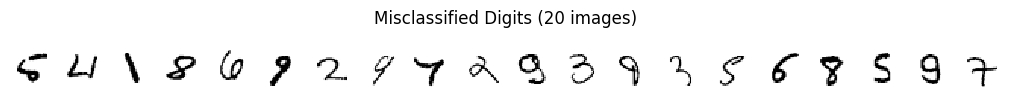

In [ ]:
misclassify_plots = min(misclassifications, 20)
fig, axes = plt.subplots(1,misclassify_plots,figsize=(10,1),layout="constrained")

for i in range(misclassify_plots):
        axes[i].imshow(test_X[misclassified_indices[i]].reshape((28,28)), interpolation='none', cmap=cm.Greys)
        axes[i].axis('off')
plt.suptitle(f"Misclassified Digits ({misclassify_plots} images)")
plt.show()

Unlike last time, the misclassifications are odd since these images look really clean to us. But some of the images have odd printing such as 4 without the vertical underline or rotated 3, or a 1 that's close to a 7, etc. This also hints to us that we have a high bias problem where the problem fails to learn the important features of the digits. Just like last time, let's summarize the model and see what's happening.

In [ ]:
categories = weights.shape[1]
scaler = MinMaxScaler()
scaler.fit(weights) # fit the weights
scaled_weights = scaler.transform(weights) # get new scaled weights

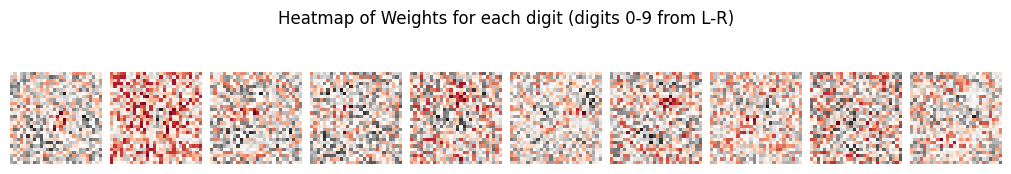

In [ ]:
fig, axes = plt.subplots(1,categories,figsize=(10,2),layout="constrained")
scaled_weightsT = scaled_weights.T
scaled_weightsT = scaled_weightsT[:,:-1] # remove the bias feature we manually added
for i in range(categories):
        axes[i].imshow(scaled_weightsT[i].reshape((28,28)), interpolation='none', cmap=cm.RdGy)
        axes[i].axis('off')
plt.suptitle(f"Heatmap of Weights for each digit (digits 0-9 from L-R)")
plt.show()

We have much bigger images now but I can already notice many patterns especially with the black and white pixels. If you look hard enough, it's very noticeable to us which digits the images are classifying. Like last time, black pixels are positive correlation and red pixels are negative correlation. Let's now visualize the confusion matrix again.

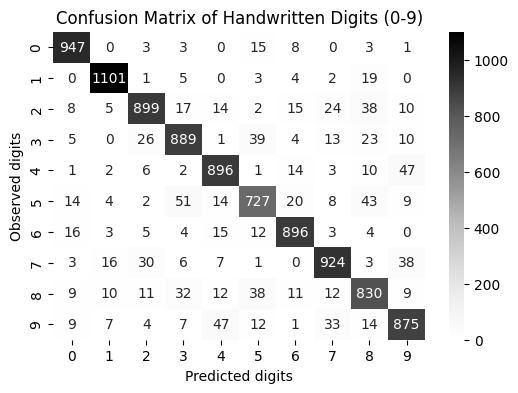

In [ ]:
cm_digits = confusion_matrix(test_y, prediction_test_samples)
plt.figure(figsize=(6, 4))
ax = sb.heatmap(cm_digits,annot=True, fmt='d', cmap='Greys')
plt.title("Confusion Matrix of Handwritten Digits (0-9)")
plt.ylabel("Observed digits")
plt.xlabel("Predicted digits")
plt.show()

From this matrix, a lot can be observed. The model fails to recognize that some 3's are actually 2's. It also mistakes many 9's as 4's and 7's. By this point, from the earlier images, it should be obvious that this makes sense to us. I won't even look at the dataset frequencies as that is unnecessary now. Anyways, using softmax regression on mnist has led us to a few insights. 1. Since the dataset is so large, we must use mini batch gradient descent where we train only some subset of the training samples. This should greatly alleviate the large matrix multiplications problem we have and also speed up execution. 2. Also, we have shown that we have a high bias problem with only 90% accuracy. We simply need a better model than the one we're using. Given these 2 important points, it's still impressive to get around 90% accuracy by only using logistic regression. This shows us the power of a simple logistic regression model. 

In [ ]:
print(classification_report(test_y, prediction_test_samples)) # show report

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.91      0.87      0.89      1032
           3       0.88      0.88      0.88      1010
           4       0.89      0.91      0.90       982
           5       0.86      0.82      0.83       892
           6       0.92      0.94      0.93       958
           7       0.90      0.90      0.90      1028
           8       0.84      0.85      0.85       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

